Intitializing Setup and Loading Data

In [ ]:
import org.apache.spark.sql.SparkSession
import scala.util.parsing.json.JSON
import scala.util.matching.Regex

var start = System.nanoTime()
var total = System.nanoTime()

//paths
val inputPath = "hdfs:///user/dic25_shared/amazon-reviews/full/reviews_devset.json"
//val inputPath = "hdfs:///user/dic25_shared/amazon-reviews/full/reviewscombined.json"
val stopwordPath = "stopwords.txt"

val TOP_K = 75
val DELIMS = "[()\\[\\]{}.!?,;:+=\\-_\"'`~#@&*%€§\\\\/0-9]+"

// === LOAD AND BRODCAST STOPWORDS ===
val stopwords = sc.textFile(stopwordPath).collect().toSet
val stopwordsBroadcast = sc.broadcast(stopwords)

// faster parsing the file by defineing the structure of the json
import org.apache.spark.sql.types._

//define sructure
val reviewSchema = StructType(Seq(
  StructField("reviewerID"    , StringType),
  StructField("asin"          , StringType),
  StructField("reviewerName"  , StringType),
  StructField("helpful"       , ArrayType(IntegerType)),
  StructField("reviewText"    , StringType),
  StructField("overall"       , DoubleType),
  StructField("summary"       , StringType),
  StructField("unixReviewTime", LongType),
  StructField("reviewTime"    , StringType),
  StructField("category"      , StringType)
))

//parse file
val reviews = spark.read
  .schema(reviewSchema)                 
  .option("mode","DROPMALFORMED")
  .json(inputPath)
  .filter($"category".isNotNull)    
  .select("category","reviewText","summary") //summary may also be importent for the evaluation
  .cache()
val parsed = reviews.as[(String,String,String)].rdd

var end = System.nanoTime()
var durationMs = (end - start) / 1e6
println(f"Runtime Parsing: $durationMs%.2f ms")

Intitializing Scala interpreter ...

Spark Web UI available at http://lbdmg01.datalab.novalocal:9999/proxy/application_1745308556449_7279
SparkContext available as 'sc' (version = 3.3.4, master = yarn, app id = application_1745308556449_7279)
SparkSession available as 'spark'


Runtime Parsing: 11437.84 ms


import org.apache.spark.sql.SparkSession
import scala.util.parsing.json.JSON
import scala.util.matching.Regex
start: Long = 138194162445065
total: Long = 138194162448900
inputPath: String = hdfs:///user/dic25_shared/amazon-reviews/full/reviews_devset.json
stopwordPath: String = Exercise_1/assets/stopwords.txt
TOP_K: Int = 75
DELIMS: String = [()\[\]{}.!?,;:+=\-_"'`~#@&*%€§\\/0-9]+
stopwords: scala.collection.immutable.Set[String] = Set(serious, latterly, absorbs, looks, particularly, used, e, printer, down, regarding, entirely, regardless, moreover, please, read, ourselves, able, behind, for, despite, s, maybe, viz, further, corresponding, x, any, wherein, across, name, allows, this, instead, in, taste, ought, myself, have, your, off, once, are, is, mon, his, oh, why, rd, knows, bulbs, ...


Tokenizing & Cleaning the Data

In [2]:
start = System.nanoTime()

//removes stopwords, replaces all delims with a whitespace and splits at ehitespaces after. Also transformes to lower case
def tokenize(text: String, stopwords: Set[String]): Set[String] = {
  if (text == null) return Set.empty
  val cleaned = text.toLowerCase.replaceAll(DELIMS, " ")
  cleaned.split("\\s+").filter(t => t.length > 1 && !stopwords.contains(t)).toSet
}

// call tokenize on parse json and stopwords
val tokenized = parsed.map {
  case (category, text, summary) =>
    val tokens = tokenize(text, stopwordsBroadcast.value)
    // At this point the summary field will be omitted. If it is relevant, we need to merge it to the text.
    (category, tokens)
}

end = System.nanoTime()
durationMs = (end - start) / 1e6
println(f"Runtime tokenizer: $durationMs%.2f ms")

Runtime tokenizer: 210.56 ms


start: Long = 138207095822889
tokenize: (text: String, stopwords: Set[String])Set[String]
tokenized: org.apache.spark.rdd.RDD[(String, Set[String])] = MapPartitionsRDD[13] at map at <console>:46
end: Long = 138207306381106
durationMs: Double = 210.558217


# Counting and cacluating chi²

Formula for the calcualtion: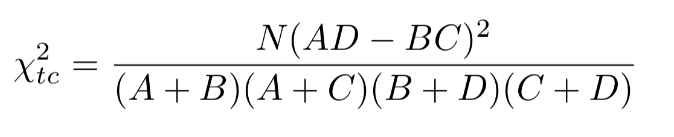

In [3]:
start = System.nanoTime()

// === Token Category and Document Statistics Computation ===

// For each (category, tokens) pair, compute:
// - ((token, category), 1) for each unique token to count token-category occurrences.
// - (("!DOC_COUNT", category), 1) to count how many documents belong to each category.
val tokenCatAndDocStats = tokenized.flatMap {
  case (cat, tokens) =>
    val tokenSet = tokens.toSet // Remove duplicate tokens within the same document
    val tokenPairs = tokenSet.map(token => ((token, cat), 1)) // Mark presence of token in category
    val docMarker = Seq((("!DOC_COUNT", cat), 1)) // Special marker to count documents per category
    tokenPairs.toSeq ++ docMarker
}.reduceByKey(_ + _) // Sum up the counts for each key

// Extract only the document counts per category from the aggregated data
val docCounts = tokenCatAndDocStats
  .filter(_._1._1 == "!DOC_COUNT") // Filter special keys for document count
  .map { case ((_, cat), count) => (cat, count) } // Map to (category, count)
  .collectAsMap() // Collect as a local Map for broadcasting

// Compute total number of documents
val totalDocs = docCounts.values.sum

// Broadcast document statistics for efficient use in distributed calculations
val docCountsBroadcast = sc.broadcast(docCounts)
val totalDocsBroadcast = sc.broadcast(totalDocs)

// Filter out the actual token-category counts, excluding the "!DOC_COUNT" entries
val tokenCatCounts = tokenCatAndDocStats
  .filter(_._1._1 != "!DOC_COUNT")

// Compute total count of each token across all categories
val tokenTotals = tokenCatCounts
  .map { case ((token, _), count) => (token, count) } // Map to (token, count)
  .reduceByKey(_ + _) // Sum counts of the same token across categories
  .collectAsMap() // Collect as a local Map for broadcasting

// Broadcast token totals for efficient reuse
val tokenTotalsBroadcast = sc.broadcast(tokenTotals)



end = System.nanoTime()
durationMs = (end - start) / 1e6
println(f"Count Runtime: $durationMs%.2f ms")



// CHI-SQUARE CALCULATION
start = System.nanoTime()
val N = totalDocsBroadcast.value.toDouble //total number of retrieved documents
println("Chi-sq")
val chi2Scores = tokenCatCounts.map {
  case ((token, cat), aCount) =>
    val A = aCount.toDouble //number of documents in c which contain t
    val T = tokenTotalsBroadcast.value.getOrElse(token, 0).toDouble
    val totalInCat = docCountsBroadcast.value.getOrElse(cat, 0).toDouble
    val B = T - A  //number of documents not in c which contain t
    val C = totalInCat - A  //number of documents in c without t
    val totalOther = N - totalInCat
    val D = totalOther - B //number of documents not in c without t
    val denom = (A + B) * (A + C) * (B + D) * (C + D)
    val chi2 = if (denom == 0) 0.0 else N * math.pow((A * D - B * C), 2) / denom
    (cat, (token, chi2))
}


end = System.nanoTime()
durationMs = (end - start) / 1e6
println(f"CHi Runtime: $durationMs%.2f ms")


Count Runtime: 14719.60 ms
Chi-sq
CHi Runtime: 16.01 ms


start: Long = 138223943944130
tokenCatAndDocStats: org.apache.spark.rdd.RDD[((String, String), Int)] = ShuffledRDD[15] at reduceByKey at <console>:47
docCounts: scala.collection.Map[String,Int] = Map(Kindle_Store -> 3205, Electronic -> 7825, Automotive -> 1374, Pet_Supplie -> 1235, Clothing_Shoes_and_Jewelry -> 5749, Baby -> 916, Grocery_and_Gourmet_Food -> 1297, Musical_Instrument -> 500, Movies_and_TV -> 4607, Book -> 22507, Tools_and_Home_Improvement -> 1926, Sports_and_Outdoor -> 3269, CDs_and_Vinyl -> 3749, Home_and_Kitche -> 4254, Apps_for_Android -> 2638, Office_Product -> 1243, Digital_Music -> 836, Health_and_Personal_Care -> 2982, Cell_Phones_and_Accessorie -> 3447, Beauty -> 2023, Toys_and_Game -> 2253, Patio_Lawn_and_Garde -> 994)
totalDocs: Int = 78829
docCountsBroadcast: o...


In [4]:
//get top k elements
val topTokensPerCategory = chi2Scores
  .groupByKey()
  .mapValues(iter => iter.toSeq.sortBy(-_._2).take(TOP_K))



topTokensPerCategory: org.apache.spark.rdd.RDD[(String, Seq[(String, Double)])] = MapPartitionsRDD[23] at mapValues at <console>:34


Export Output to output_rdd.txt

In [5]:
import scala.reflect.io.File

//format output as: <category> [term:chi2]
val output = topTokensPerCategory.map { case (category, terms) =>
  val formattedTerms = terms.map { case (term, chi2) =>
    s"$term:$chi2"
  }.mkString(" ")
  s"<$category> $formattedTerms"
}

//create and save to output file
val file = File("output_rdd.txt")
val sorted_output = output.collect().sorted
file.writeAll(sorted_output.mkString("\n"))


// merging vocabluary
val mergedVocab = topTokensPerCategory.flatMap(_._2.map(_._1)).distinct().collect().sorted

// Append the sorted vocab to file
file.appendAll("\n" + mergedVocab.mkString(" "))

end = System.nanoTime()
durationMs = (end - total) / 1e6
println(f"Total Runtime: $durationMs%.2f ms")

25/05/13 22:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1544.4 KiB
25/05/13 22:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1544.8 KiB
Total Runtime: 34662.39 ms


import scala.reflect.io.File
output: org.apache.spark.rdd.RDD[String] = MapPartitionsRDD[24] at map at <console>:36
file: scala.reflect.io.File = output_rdd.txt
sorted_output: Array[String] = Array(<Apps_for_Android> games:3081.1493374842926 play:2158.369406820129 graphics:1505.51089773515 kindle:1470.820942569012 addictive:1311.9055627277771 challenging:1038.1284558527927 coins:1002.6647889526382 addicting:990.8441134974867 fire:956.1470053110604 levels:825.3813282736016 playing:692.9340396014182 ads:642.3969794099202 puzzles:596.7716753070063 apps:548.7810653104153 free:500.9884786241356 bingo:409.2358492981346 mahjong:322.00891943980963 download:303.8649278202287 faotd:288.8577201586641 facebook:282.5170543702901 downloaded:262.77022492215735 hints:242.61029019440056 solitaire:211.64...
